In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np 
import pandas as pd 

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

In [2]:
df = pd.read_csv("E:/Lakni UOC/4th Year/1st sem/ST 4052 - Statistical Learning II/2.grp project 1/codes_diabetes/diabetes_prediction_dataset.csv")

In [3]:
df_copy = df.copy()

In [4]:
# Handle duplicates
duplicate_rows_data = df_copy[df_copy.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [5]:
df_copy.drop_duplicates(inplace=True)
print(f'without duplicates:{df_copy.shape}')

without duplicates:(96146, 9)


In [6]:
# Remove Unneccessary value [0.02%]
df2 = df_copy[df_copy['gender'] != 'Other']


df2.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96128 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96128 non-null  object 
 1   age                  96128 non-null  float64
 2   hypertension         96128 non-null  int64  
 3   heart_disease        96128 non-null  int64  
 4   smoking_history      96128 non-null  object 
 5   bmi                  96128 non-null  float64
 6   HbA1c_level          96128 non-null  float64
 7   blood_glucose_level  96128 non-null  int64  
 8   diabetes             96128 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.3+ MB


# smoking history

In [8]:
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status == 'never':
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'
    else:
        return 'no info'
    
# Apply the function to the 'smoking_history' column
df2['smoking_history'] = df2['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df2['smoking_history'].value_counts())
df2.head()

non-smoker     34395
no info        32881
past_smoker    19655
current         9197
Name: smoking_history, dtype: int64


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,non-smoker,25.19,6.60,140,0
1,Female,54.00,0,0,no info,27.32,6.60,80,0
2,Male,28.00,0,0,non-smoker,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


# encoding

In [9]:
data = df2.copy()

In [10]:
gender = {'Female':0,'Male':1}
data['gender'] =data['gender'].replace(gender)
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.00,0,1,non-smoker,25.19,6.60,140,0
1,0,54.00,0,0,no info,27.32,6.60,80,0
2,1,28.00,0,0,non-smoker,27.32,5.70,158,0
3,0,36.00,0,0,current,23.45,5.00,155,0
4,1,76.00,1,1,current,20.14,4.80,155,0


In [11]:
def perform_one_hot_encoding(df2, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df2[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df2 = pd.concat([df2.drop(column_name, axis=1), dummies], axis=1)

    return df2

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

In [12]:
data.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_no info,smoking_history_non-smoker,smoking_history_past_smoker
0,0,80.00,0,1,25.19,6.60,140,0,0,0,1,0
1,0,54.00,0,0,27.32,6.60,80,0,0,1,0,0
2,1,28.00,0,0,27.32,5.70,158,0,0,0,1,0
3,0,36.00,0,0,23.45,5.00,155,0,1,0,0,0
4,1,76.00,1,1,20.14,4.80,155,0,1,0,0,0


# split to train and test

In [13]:
training_data, testing_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 76902
No. of testing examples: 19226


In [14]:
x = training_data.drop(['diabetes'],axis=1)
y = training_data["diabetes"]
x.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_current,smoking_history_no info,smoking_history_non-smoker,smoking_history_past_smoker
39756,0,8.00,0,0,15.90,3.50,90,0,1,0,0
75304,1,65.00,1,1,28.49,8.80,145,0,0,1,0
19765,1,64.00,1,0,33.69,4.80,80,0,1,0,0
97291,1,49.00,0,0,21.84,5.00,130,0,0,1,0
37660,0,26.00,0,0,21.95,5.70,158,0,0,1,0


In [15]:
# Get the column names from the DataFrame before creating 'x'
x_column_names = training_data.drop(['diabetes'], axis=1).columns.tolist()

# Print the column names
print(x_column_names)

['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history_current', 'smoking_history_no info', 'smoking_history_non-smoker', 'smoking_history_past_smoker']


{'copy': True, 'max_iter': 500, 'n_components': 3, 'scale': True, 'tol': 1e-06}


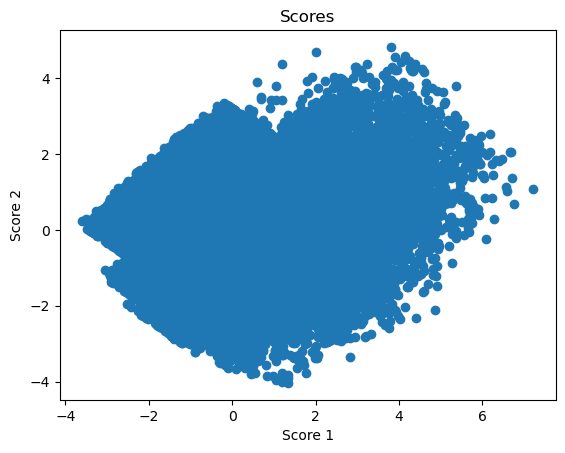

<Figure size 2000x1500 with 0 Axes>

In [16]:
from sklearn.cross_decomposition import PLSRegression

model_pls = PLSRegression(scale=True, n_components=3, max_iter=500, tol=1e-06, copy=True)
model_pls.fit(x, y)

print(model_pls.get_params()) # to get information about the model's parameters

# Get the scores and loading plots
scores = model_pls.transform(x)

# Plot the scores
import matplotlib.pyplot as plt
plt.scatter(scores[:, 0], scores[:, 1])
plt.xlabel('Score 1')
plt.ylabel('Score 2')
plt.title('Scores')
plt.figure(figsize=(20, 15))
plt.show()


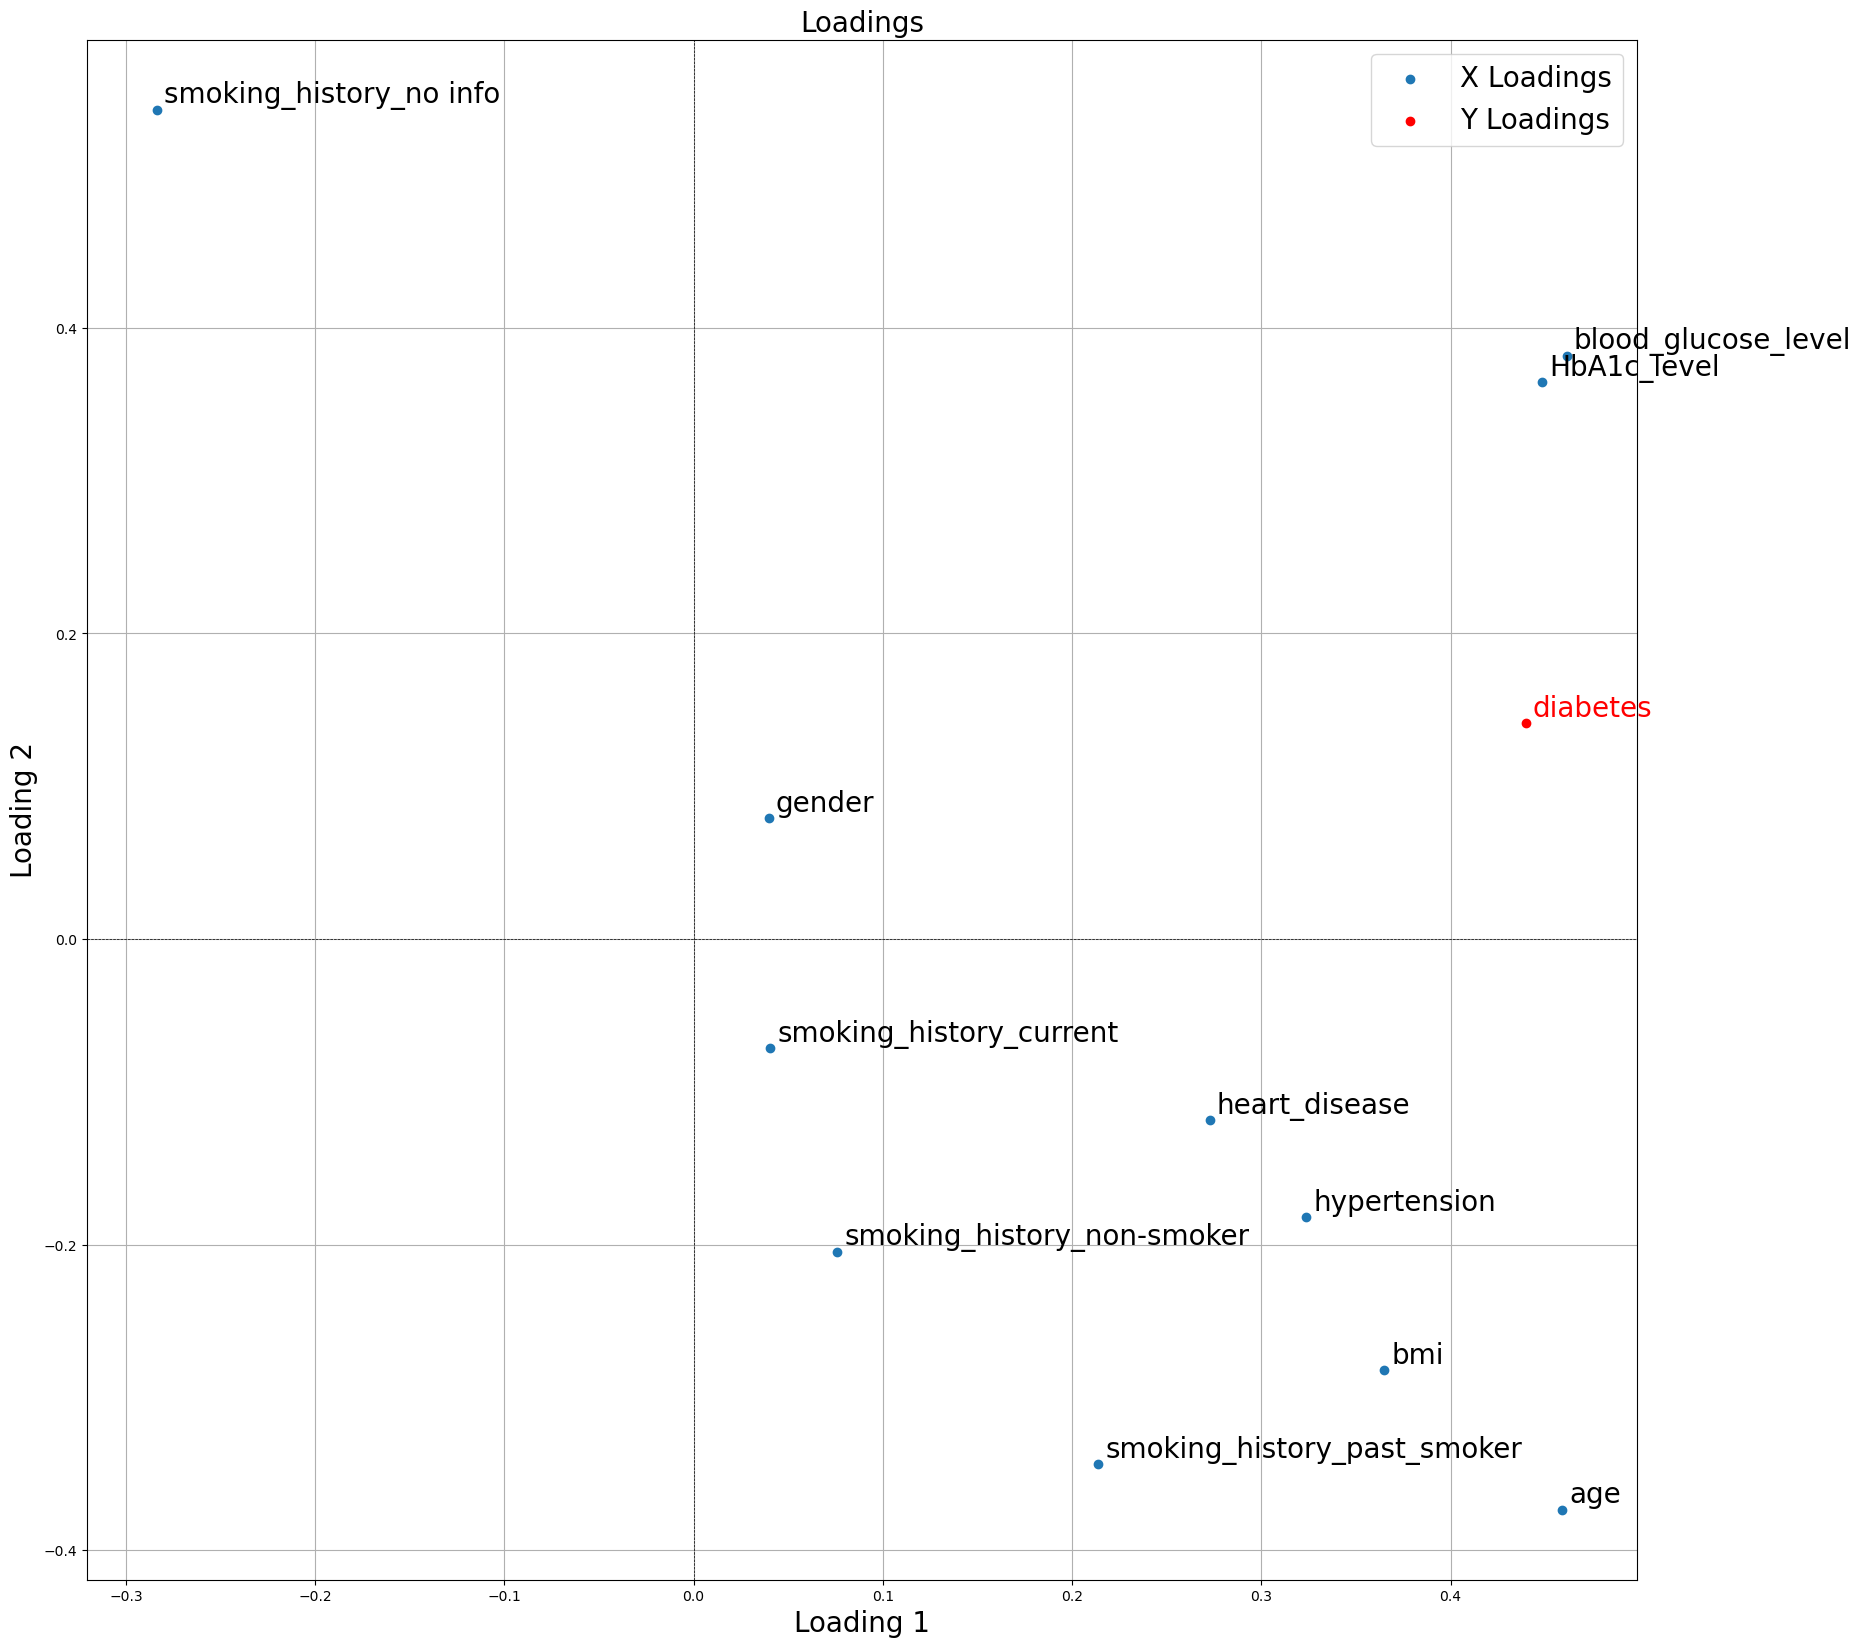

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Assuming you have your independent variables 'X' and dependent variable 'y'
# Replace X and y with your actual data

# Create a PLS regression model with 2 latent components
pls = PLSRegression(n_components=2)

# Fit the model
pls.fit(x, y)

# Get the loadings for X
loadings_X = pls.x_loadings_

# Get the loadings for y
loadings_y = pls.y_loadings_

# Plot the loadings for X
plt.figure(figsize=(20, 20))
plt.scatter(loadings_X[:, 0], loadings_X[:, 1], label='X Loadings')

# Plot the loadings for y
plt.scatter(loadings_y[:, 0], loadings_y[:, 1], color='red', marker='o', label='Y Loadings')

# Add gridlines
plt.grid(True)

# Add labels to each data point with x variable names
for i, (x, y) in enumerate(loadings_X):
    plt.annotate(x_column_names[i], (x, y), xytext=(5, 5), textcoords='offset points', fontsize=20)

# Add labels to each data point with y variable names
for i, (x, y) in enumerate(loadings_y):
    plt.annotate(f'diabetes', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=20, color='red')

# Add axis labels
plt.xlabel('Loading 1',fontsize=20)
plt.ylabel('Loading 2',fontsize=20)
plt.title('Loadings',fontsize=20)
# Add lines for the origin (0,0)
plt.axhline(0, color='black', linewidth=0.5, linestyle='dashed')
plt.axvline(0, color='black', linewidth=0.5, linestyle='dashed')

# Add legend
plt.legend(fontsize=20)

plt.show()
